## Initial Setup: Toy datasets

### Dataset 1: Cluster Dataset

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import sklearn
import sklearn.metrics.cluster

In [43]:
def generate_cluster_dataset(K=10,variance=1):
    """
    
    Generates a toy dataset with a fixed number of Gaussian clusters.
    
    Returns:
    X - data
    z - true cluster assignments
    K - number of clusters
    
    """

    ## 3D GMM with a fixed number of clusters, K and dimension, D
    D = 3
    # for now, fix the covariance matrix for each cluster
    covariance = variance*np.eye(3)

    # sample the means. uniformly drawn from a box [-W,W] x [-W,W] x [-W,W]
    # shape: K x D
    W = 10
    np.random.seed(1) # for reproducibility
    means = np.random.uniform(0,2*W,(K,D))-W
    #print means


    # (inefficiently) sample the datapoints. for now, the cluster weights are equal
    N = 1000
    z = np.random.randint(0,K-1,(N,1))
    X = np.zeros((N,D))

    # consider each cluster, find the points that were assigned to that cluster, and then sample from that cluster
    for k in xrange(K):
        (points_in_k, _) = np.where(z == k)
        samples = np.random.multivariate_normal(means[k], covariance, size=(len(points_in_k)))
        X[points_in_k,:] = samples  

    return X, z

In [6]:
def plot_clusters(X, z):
    """
    Plots clusters, given by data matrix and labels z
    
    X: N X 3 matrix
    z: vector
    
    """
    # from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    xs = X[:,0]
    ys = X[:,1]
    zs = X[:,2]

    ax.scatter(xs,ys,zs, c = z)

    plt.show()

### Dataset 2: Hypersphere Dataset

In [7]:
import quaternion_utils as qutils
import quaternion

In [8]:
def apply_axis_angle(v, k, theta):
    """
    Applies an axis-angle rotation about k by theta to vector v

    v: vector to be rotated
    k: unit vector that we wish to rotate around
    theta: angle to rotate

    Returns: rotated vector v
    
    """    

    assert np.linalg.norm(k) != 0

    # generate rotation quaternion
    rotation_quat = qutils.axisangle_to_q(k, theta)

    # rotate vector v according to rotation quaternion    
    v_rot = qutils.qv_mult(rotation_quat, v)
    
    return v_rot

In [9]:
def rotate_points(data, orig_vector, dest_vector):
    """
    Rotates data vectors in S_2 based on rotation from orig_vector to final_vector.
    
    data: data points to be rotated (N x 3)
    orig_vector: initial orientation direction
    dest_vector: final orientation direction
    
    """
    axis = np.cross(orig_vector, dest_vector)
    angle = np.arccos(np.dot(orig_vector, dest_vector)/(np.linalg.norm(orig_vector) * np.linalg.norm(orig_vector)))
    
    # TODO: maybe need to change this to np.apply_along_axis, so ?
    
    # if angle is (sufficently close) to 0, then make the axis random
    angle_tol = 1e-5
    if np.abs(angle) <= angle_tol:
        axis = np.array([0,0,1])
        
    # if angle is (sufficiently close) to 180, then we can choose any axis in the x-y plane
    # for simplicity, just choose x-axis
    if np.abs(angle - np.pi) <= angle_tol:
        axis = np.array([1,0,0])
    
    
    
    assert np.linalg.norm(axis) != 0, "Axis of rotation should not be the zero vector."
    
    def axis_angle_transform(point):
        return apply_axis_angle(point, axis, angle)
    
    return np.apply_along_axis(axis_angle_transform, 1, data)

In [10]:
def sample_from_vMF(mu, kappa, num_samples):
    """
    Uses method from Jakob (2012) and Jung (2009) and others 
    to sample from a vMF distribution on the 2-sphere.
    
    Parameters:
    mu - direction vector (3 x 1)
    kappa - concentration parameter (constant)
    N - number of samples
    
    Returns:
    omega - the sampled points
    
    """
    np.random.seed(32)  # for reproducibility
        
    #### Step 1: sample from V - uniformly distributed on unit circle
    thetas = np.random.uniform(low = -np.pi, high = np.pi, size=num_samples)
    v = np.transpose(np.vstack((np.cos(thetas), np.sin(thetas))))
        
    #### Step 2: sample from W
    # uses inverse CDF method
    
    # generate uniform samples on [0,1]
    xi = np.random.uniform(size=num_samples)
    
    # pass through inverse CDF
    
    w = 1.0/kappa * np.log(np.exp(-kappa) + 2*xi*np.sinh(kappa))
    w = np.reshape(w, (num_samples,1))
    
    #### Step 3: combine to form (w_kappa) samples
        
    omega = np.hstack((np.sqrt(1-w**2)*v,w))
                
    #### Step 4: finally, apply rotation matrix to conver from (0,0,1) to mu
    
    mu_ref = np.array([0,0,1])    # standard, reference direction
        
    omega = rotate_points(omega, mu_ref, mu)
    
    #print "(final, rotated) omega: ", omega
    
    return omega

In [51]:
def generate_hypersphere_dataset(K=10, tau=100):
    """
    
    Generates a toy 3D hypersphere dataset with a fixed number of vMF clusters. 
    
    [Goal is to generate data from a finite-dimensional vMF mixture]
    
    Based on Straub (2015)
    
    Hyperparameters:
    - alpha: Dirichlet hyperparameter
    - K: number of clusters
    - mu_0:  prior direction for vMF means
    - tau_0: prior concentration for vMF means
    
    Returns:
    X - data
    z - true surface cluster assignments
    """

    np.random.seed(5) # for reproducibility
    
    ## specify hyper-parameters
    alpha = 1 # Dirichlet hyperparameter
    #K = 10      # number of clusters
    D = 3       # dimensionality of the data
    
    ## sample cluster weights and directional means
    
    # weights are Dir(alpha)
    weights = np.random.dirichlet(alpha*np.ones(K))
    
    # means are drawn from a vMF(mu_0, tau_0)
    mu_0 = np.array([1,0,0])
    tau_0 = 1
    mu = sample_from_vMF(mu_0, tau_0, num_samples=K)
    
    #print "weights:", weights
    #print "mu:", mu

    ## sample datapoints
    
    # (inefficiently) sample the datapoints. for now, the cluster weights are equal
    N = 1000
    #tau = 100    # hyperparameter: dispersion factor for generating data
    #z = np.random.multinomial(N, weights, size=1)    # TODO: might be more efficient, but for now will skip
    z = np.random.choice(np.arange(K),N,p=weights)
    z = np.reshape(z,(N,1))
    X = np.zeros((N,D))
    
    # consider each cluster, find the points that were assigned to that cluster, and then sample from that cluster
    for k in xrange(K):
        (points_in_k, _) = np.where(z == k)
        if(len(points_in_k) > 0):
            samples = sample_from_vMF(mu[k], tau, num_samples=len(points_in_k))
            X[points_in_k,:] = samples  

    return X, z

In [12]:
def plot_vMF_data(X, z=None):
    """
    Plots raw data, given by data matrix X.
    
    X: N X 3 matrix    
    z: (optional) cluster assignments
    """
    # from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    xs = X[:,0]
    ys = X[:,1]
    zs = X[:,2]
    
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])

    if z is None:
        ax.scatter(xs,ys,zs)
    else:
        ax.scatter(xs,ys,zs, c = z)

    plt.show()

## MAD-Bayes: DP-GMM

In [13]:
## Based on Kulis and Jordan, 2012

def mad_bayes_dpgmm(X, lmb = 0.25, num_iter = 10):
    """
    Runs MAD-Bayes (small-variance) inference algorithm for a GMM.
    
    X: input data (N x D)
    
    2 hyperparameters (distance and convergence):
    lmb: cluster penalty parameter - lower indicates a greater willingness to create clusters
    num_iter: number of iterations to run algorithm
    
    Returns:
    K: estimated K
    z: inferred z-labels for each cluster
    mu: estimated cluster means
    """
    
    # initialization
    (N,D) = X.shape
    K = 1
    mu = np.array([np.average(X, axis=0)])
    z = np.zeros((N,1))    # cluster assignments - initially everything is assigned to the same cluster
    
    #print "initial mean: ", mu
    #print "closest distance to initial mean: ", np.amin(np.linalg.norm(X-mu,axis=1))
    
    for i in xrange(num_iter):  
        # check to see, for each data point, if the closest cluster is larger than lambda away
        for j in xrange(N):
            x = X[j]
            # calculate distances between point and all of the existing clusters
            distances = np.linalg.norm(x - mu,axis=1)   # K x 1 array (x-mu is K x D)
            min_dist = np.amin(distances)               # minimum distance to any of existing clusters
            if min_dist > lmb:
                # create a new cluster!
                K+=1
                z[j] = K
                mu = np.vstack((mu,x))
            else:
                # assign x to min-dist cluster
                z[j] = np.argmin(distances)

        #print "mu before re-assignment: ", mu     
        
        # check to see if any of the cluster means have NOTHING assigned to them
        # if so, remove them and re-adjust the z's accordingly.
        k = 0
        while k < K:
            (indices, _) = np.where(z == k)
            if len(indices) == 0:
                # delete mean
                mu = np.delete(mu, (k), axis=0) 
                
                # decrement K
                K -= 1
                
                # re-label all z's. everything that had a label greater than k needs to 
                # be downshifted by 1
                (indices_two, _) = np.where(z > k)
                z[indices_two] -= 1
                
                # decrement counter to reflect this re-labeling
                k -= 1
                
            k += 1 


        # re-compute cluster means (inefficently)
        for k in xrange(K):
            (indices, _) = np.where(z == k)
            #print indices
            assert len(indices) != 0
            mu[k] = np.average(X[indices],axis=0)
            
        #print "K: ", K
        
        assert K == len(mu)
        #print "mu after re-assignment: ", mu
        
    #print "final z: ", z
    
    return K,z,mu

### Parameter Sweep: λ

In [14]:
def gmm_lambda_sweep(X, z_true, min_lambda, max_lambda, lambda_jump, debug=False):
    """
    Returns the estimated K values, the lambda value that maximizes NMI, and the maximum NMI
    """
    lambda_list = np.arange(min_lambda, max_lambda, lambda_jump)
    est_K_list = []
    best_lambda = None
    best_score = 0.0
    for lb in lambda_list:
        (est_K, est_z, est_mu) = mad_bayes_dpgmm(X, lmb=lb)
        est_K_list.append(est_K)
        (N,_) = est_z.shape
        nmi_score = sklearn.metrics.cluster.normalized_mutual_info_score(np.reshape(est_z, (N,)), np.reshape(z_true, (N,)))
        if debug:
            print "lb:", lb, "est_K:", est_K
            print "NMI score:", nmi_score
        if best_lambda == None or nmi_score > best_score:
            best_lambda = lb
            best_score = nmi_score

    return est_K_list, best_lambda, best_score

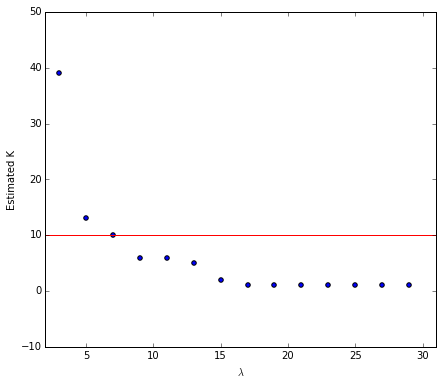

In [232]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('$\lambda$')
ax.set_ylabel('Estimated K')

xs = lambda_list
ys = est_K_list

xs_ground_truth = np.arange(min_lambda - 1, max_lambda + 3, lambda_jump)
ground_truth = true_K_GMM*np.ones(len(xs_ground_truth))

ax.scatter(xs,ys)
ax.plot(xs_ground_truth, ground_truth, color='r')

ax.set_xlim([min_lambda-1, max_lambda+1])

plt.show()

### Robustness to K

In [15]:
K_values = np.arange(5, 50, 5)
scores = []
best_lambdas = []
for K in K_values:
    X, z_true = generate_cluster_dataset(K)
    (K_list, best_lambda, best_score) = gmm_lambda_sweep(X, z_true, 1, 50, 1)
    print "ground truth K:", K
    print "best lambda:", best_lambda
    print "best NMI score:", best_score
    best_lambdas.append(best_lambda)
    scores.append(best_score)

lb: 1 est_K: 229
NMI score: 0.5169427766326378
lb: 2 est_K: 60
NMI score: 0.5945110407531118
lb: 3 est_K: 23
NMI score: 0.6710648446212394
lb: 4 est_K: 7
NMI score: 0.853710419778621
lb: 5 est_K: 6
NMI score: 0.8910332058294184
lb: 6 est_K: 6
NMI score: 0.8894391264218857
lb: 7 est_K: 5
NMI score: 0.9423084534342652
lb: 8 est_K: 5
NMI score: 0.9409181782321934
lb: 9 est_K: 4
NMI score: 1.0
lb: 10 est_K: 3
NMI score: 0.8657888129559443
lb: 11 est_K: 3
NMI score: 0.8657888129559443
lb: 12 est_K: 1
NMI score: -2.220446049250313e-06
lb: 13 est_K: 1
NMI score: -2.220446049250313e-06
lb: 14 est_K: 1
NMI score: -2.220446049250313e-06
lb: 15 est_K: 1
NMI score: -2.220446049250313e-06
lb: 16 est_K: 1
NMI score: -2.220446049250313e-06
lb: 17 est_K: 1
NMI score: -2.220446049250313e-06
lb: 18 est_K: 1
NMI score: -2.220446049250313e-06
lb: 19 est_K: 1
NMI score: -2.220446049250313e-06
lb: 20 est_K: 1
NMI score: -2.220446049250313e-06
lb: 21 est_K: 1
NMI score: -2.220446049250313e-06
lb: 22 est_K: 1

lb: 20 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 21 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 22 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 23 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 24 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 25 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 26 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 27 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 28 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 29 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 30 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 31 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 32 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 33 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 34 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 35 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 36 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 37 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 38 est_K: 1
NMI score: -2.7755575615628914e-07
lb: 39 est_K: 1
NMI score: -2.7

lb: 35 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 36 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 37 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 38 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 39 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 40 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 41 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 42 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 43 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 44 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 45 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 46 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 47 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 48 est_K: 1
NMI score: -2.6367796834847468e-06
lb: 49 est_K: 1
NMI score: -2.6367796834847468e-06
ground truth K: 35
best lambda: 4
best NMI score: 0.9088115494679538
lb: 1 est_K: 541
NMI score: 0.7545396031104133
lb: 2 est_K: 253
NMI score: 0.7822258284200654
lb: 3 est_K: 107
NMI score: 0.8441562943147837
lb: 4 est_K: 48
NMI score

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


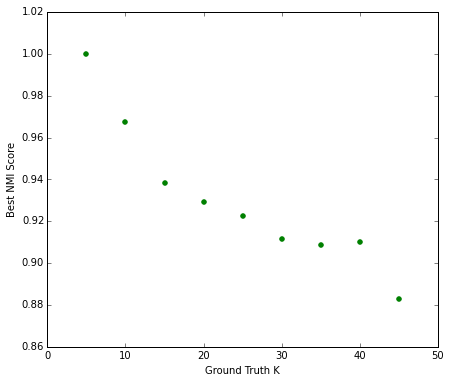

In [16]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Ground Truth K')
ax.set_ylabel('Best NMI Score')

xs = K_values
ys = scores

ax.scatter(xs,ys,color='g')

#ax.set_xlim([min_lambda-1, max_lambda+1])

plt.show()

### Robustness to noise variance

In [46]:
K = 10 # fix K
noise_values = np.arange(1, 10, 1)
scores = []
best_lambdas = []
for var in noise_values:
    X, z_true = generate_cluster_dataset(K,variance=var)
    (K_list, best_lambda, best_score) = gmm_lambda_sweep(X, z_true, 1, 50, 1)
    print "ground truth K:", K
    print "best lambda:", best_lambda
    print "best NMI score:", best_score
    best_lambdas.append(best_lambda)
    scores.append(best_score)

ground truth K: 10
best lambda: 7
best NMI score: 0.967581610236831
ground truth K: 10
best lambda: 10
best NMI score: 0.9219119902268056
ground truth K: 10
best lambda: 10
best NMI score: 0.8905903299826401
ground truth K: 10
best lambda: 11
best NMI score: 0.859504217847337
ground truth K: 10
best lambda: 11
best NMI score: 0.8177278846426406
ground truth K: 10
best lambda: 11
best NMI score: 0.7794983384741346
ground truth K: 10
best lambda: 13
best NMI score: 0.7411635911596592
ground truth K: 10
best lambda: 13
best NMI score: 0.697258537697079
ground truth K: 10
best lambda: 13
best NMI score: 0.670512935031775


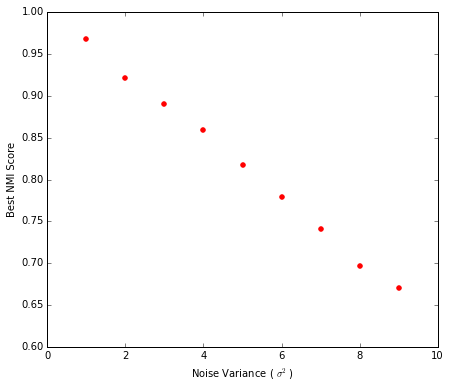

In [50]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Noise Variance ( $\sigma^2$)')
ax.set_ylabel('Best NMI Score')

xs = noise_values
ys = scores

ax.scatter(xs,ys,color='r')

#ax.set_xlim([min_lambda-1, max_lambda+1])

plt.show()

## MAD-Bayes: DP-vMF-MM

In [17]:
## Based on Straub et al., 2015

def mad_bayes_dpvmf(X, lmb = -1, num_iter = 10):
    """
    Runs MAD-Bayes (small-variance) inference algorithm for a vMF mixture.
    
    X: input data (N x D)
    
    2 hyperparameters (distance and convergence):
    lmb: cluster penalty parameter 
        - lower indicates a lower willingness to create clusters
        - should be in [-2, 0]
    num_iter: number of iterations to run algorithm
    
    Returns:
    K: estimated K
    z: inferred z-labels for each cluster
    mu: estimated cluster means
    """
    
    #initialization
    (N,D) = X.shape
    K = 1
    sum_dir = np.sum(X, axis=0)
    mu = np.array([sum_dir/np.linalg.norm(sum_dir)])
    z = np.zeros((N,1))    # cluster assignments - initially everything is assigned to the same cluster
    
    #print "initial mean: ", mu
    #print "closest distance to initial mean: ", np.amin(np.linalg.norm(X-mu,axis=1))
    
    #print "--------------------"
    
    for i in xrange(num_iter): 
        #if i % 10 == 0:
        #    print "iteration number: ", i
        
        # check to see, for each data point, if the closest cluster is larger than lambda away, 
        # in the inner product sense
        for j in xrange(N):
            x = X[j]
            # calculate inner product between point and all of the existing clusters
            inner_prods = np.dot(mu, np.transpose(x))           # K x 1 array (x is 1 X D, mu is K x D)
            max_inner_prod = np.amax(inner_prods)               # max inner product to any of existing clusters
            if max_inner_prod < lmb + 1:
                # create a new cluster!
                K+=1
                z[j] = K
                mu = np.vstack((mu,x))
            else:
                # assign x to min-dist cluster
                z[j] = np.argmax(inner_prods)

        #print "mu before re-assignment: ", mu     
        
        
        # check to see if any of the cluster means have NOTHING assigned to them
        # if so, remove them and re-adjust the z's accordingly.
        k = 0
        while k < K:
            (indices, _) = np.where(z == k)
            if len(indices) == 0:
                # delete mean
                mu = np.delete(mu, (k), axis=0) 
                
                # decrement K
                K -= 1
                
                # re-label all z's. everything that had a label greater than k needs to 
                # be downshifted by 1
                (indices_two, _) = np.where(z > k)
                z[indices_two] -= 1
                
                # decrement counter to reflect this re-labeling
                k -= 1
                
            k += 1 
            
        #if i % 10 == 0:
        #    print "estimated K: ", K

            
        # re-compute cluster means (inefficently)
        for k in xrange(K):
            (indices, _) = np.where(z == k)
            #print indices
            assert len(indices) != 0
            sum_xs = np.sum(X[indices],axis=0)
            mu[k] = sum_xs/np.linalg.norm(sum_xs)
            
        #print "K: ", K
        
        assert K == len(mu)
        
        #print "mu after re-assignment: ", mu
        
        
        
    #print "final z: ", z
    
    #print [np.where(z==k)[0] for k in xrange(K)]
    
    return K,z,mu

### Parameter Sweep: λ

In [36]:
def vmf_lambda_sweep(X, z_true, min_lambda, max_lambda, lambda_jump, debug=False):
    """
    Returns the estimated K values, the lambda value that maximizes NMI, and the maximum NMI
    """
    lambda_list = np.arange(min_lambda, max_lambda, lambda_jump)
    est_K_list = []
    best_lambda = None
    best_score = 0.0
    for lb in lambda_list:
        (est_K, est_z, est_mu) = mad_bayes_dpvmf(X, lmb=lb)
        est_K_list.append(est_K)
        (N,_) = est_z.shape
        nmi_score = sklearn.metrics.cluster.normalized_mutual_info_score(np.reshape(est_z, (N,)), np.reshape(z_true, (N,)))
        if debug:
            print "lb:", lb, "est_K:", est_K
            print "NMI score:", nmi_score
        if best_lambda == None or nmi_score > best_score:
            best_lambda = lb
            best_score = nmi_score

    return est_K_list, best_lambda, best_score

In [37]:
min_lambda = -2
max_lambda = -0.025
lambda_jump = 0.025
lambda_list = np.arange(min_lambda, max_lambda, lambda_jump)
(est_K_list, best_lambda, best_score) = vmf_lambda_sweep(X_hyp, z_true_hyp, min_lambda, max_lambda, lambda_jump, debug=False)

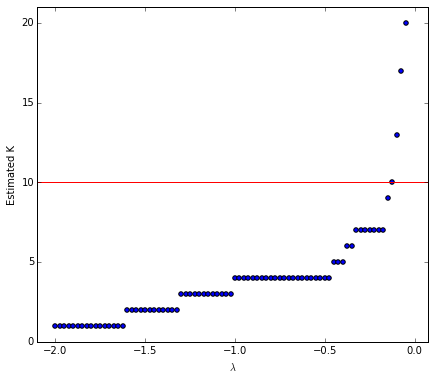

In [38]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('$\lambda$')
ax.set_ylabel('Estimated K')

xs = lambda_list
ys = est_K_list

xs_ground_truth = np.arange(min_lambda - 1, max_lambda + 3, lambda_jump)
ground_truth = true_K_vMF*np.ones(len(xs_ground_truth))

ax.scatter(xs,ys)
ax.plot(xs_ground_truth, ground_truth, color='r')

ax.set_xlim([min_lambda-0.1, max_lambda+0.1])
ax.set_ylim([min(est_K_list)-1, max(est_K_list)+1])

plt.show()

### Robustness to K

In [39]:
K_values = np.arange(5, 50, 5)
scores = []
best_lambdas = []
for K in K_values:
    X, z_true = generate_hypersphere_dataset(K)
    (K_list, best_lambda, best_score) = vmf_lambda_sweep(X, z_true, -2, -0.025, 0.025)
    print "ground truth K:", K
    print "best lambda:", best_lambda
    print "best NMI score:", best_score
    best_lambdas.append(best_lambda)
    scores.append(best_score)

ground truth K: 5
best lambda: -0.2250000000000063
best NMI score: 0.9915362753132274
ground truth K: 10
best lambda: -0.12500000000000666
best NMI score: 0.9328463989137133
ground truth K: 15
best lambda: -0.12500000000000666
best NMI score: 0.9309102462988308
ground truth K: 20
best lambda: -0.10000000000000675
best NMI score: 0.9237154936870935
ground truth K: 25
best lambda: -0.12500000000000666
best NMI score: 0.8916870889666145
ground truth K: 30
best lambda: -0.12500000000000666
best NMI score: 0.8505902007969284
ground truth K: 35
best lambda: -0.10000000000000675
best NMI score: 0.8795886000184064
ground truth K: 40
best lambda: -0.10000000000000675
best NMI score: 0.8812827771956077
ground truth K: 45
best lambda: -0.12500000000000666
best NMI score: 0.893137113571648


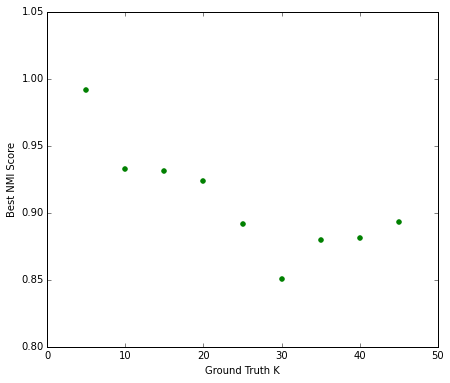

In [42]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Ground Truth K')
ax.set_ylabel('Best NMI Score')

xs = K_values
ys = scores

ax.scatter(xs,ys,color='g')

#ax.set_ylim([0,1])

plt.show()

### Robustness to noise variance

In [59]:
K = 10 # fix K
tau_values = np.arange(10, 200, 10)
scores = []
best_lambdas = []
for tau in tau_values:
    X, z_true = generate_hypersphere_dataset(K,tau=tau)
    (K_list, best_lambda, best_score) = vmf_lambda_sweep(X, z_true, -2, -0.025, 0.025)
    print "ground truth K:", K
    print "best lambda:", best_lambda
    print "best NMI score:", best_score
    best_lambdas.append(best_lambda)
    scores.append(best_score)

ground truth K: 10
best lambda: -0.6250000000000049
best NMI score: 0.6421181386342085
ground truth K: 10
best lambda: -0.4750000000000054
best NMI score: 0.8169387754272152
ground truth K: 10
best lambda: -0.4750000000000054
best NMI score: 0.8894242124939499
ground truth K: 10
best lambda: -0.4500000000000055
best NMI score: 0.925585570679169
ground truth K: 10
best lambda: -0.4250000000000056
best NMI score: 0.9302298900087954
ground truth K: 10
best lambda: -0.35000000000000586
best NMI score: 0.9471183274370835
ground truth K: 10
best lambda: -0.32500000000000595
best NMI score: 0.9542507761146524
ground truth K: 10
best lambda: -0.32500000000000595
best NMI score: 0.9542507761146524
ground truth K: 10
best lambda: -0.3750000000000058
best NMI score: 0.9325960103628353
ground truth K: 10
best lambda: -0.12500000000000666
best NMI score: 0.9328463989137133
ground truth K: 10
best lambda: -0.32500000000000595
best NMI score: 0.9589482064141804
ground truth K: 10
best lambda: -0.1000

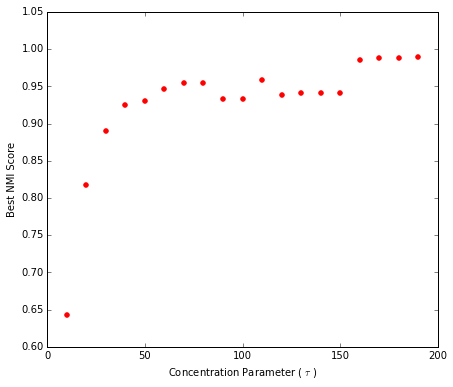

In [75]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Concentration Parameter ( $\\tau$ )')
ax.set_ylabel('Best NMI Score')

xs = tau_values
ys = scores

ax.scatter(xs,ys,color='r')

#ax.set_xlim([min_lambda-1, max_lambda+1])

plt.show()